## Init - always run

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import brier_score_loss

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform, loguniform, beta
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import optuna
from optuna.trial import TrialState

import warnings
warnings.filterwarnings("ignore")

/home/JanTar/miniconda3/envs/automl1/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Datasets

In [2]:
X1 = pd.read_csv("preprocessed_datasets/bank_data.csv")
y1 = pd.read_csv("preprocessed_datasets/bank_target.csv").squeeze()
X2 = pd.read_csv("preprocessed_datasets/gym_data.csv")
y2 = pd.read_csv("preprocessed_datasets/gym_target.csv").squeeze()
X3 = pd.read_csv("preprocessed_datasets/heartDisease_data.csv")
y3 = pd.read_csv("preprocessed_datasets/heartDisease_target.csv").squeeze()
X4 = pd.read_csv("preprocessed_datasets/titanic_data.csv")
y4 = pd.read_csv("preprocessed_datasets/titanic_target.csv").squeeze()

In [3]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)

In [4]:
datasets = [
    (X1_train, X1_test, y1_train, y1_test, "Bank"),
    (X2_train, X2_test, y2_train, y2_test, "Gym"),
    (X3_train, X3_test, y3_train, y3_test, "Heart Disease"),
    (X4_train, X4_test, y4_train, y4_test, "Titanic")
]
baseline_brier_scores = []


model = RandomForestClassifier(random_state=42)

for X_train, X_test, y_train, y_test, _ in tqdm(datasets, desc="Processing datasets"):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)
    baseline_brier_scores.append(brier)

for i, (brier, (_, _, _, _, dataset_name)) in enumerate(zip(baseline_brier_scores, datasets), 1):
    print(f"Dataset {i} ({dataset_name}): Baseline Brier score = {brier:.4f}")

Processing datasets: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

Dataset 1 (Bank): Baseline Brier score = 0.1892
Dataset 2 (Gym): Baseline Brier score = 0.1819
Dataset 3 (Heart Disease): Baseline Brier score = 0.1067
Dataset 4 (Titanic): Baseline Brier score = 0.1520


### Constansts and functions

In [11]:
N_ITER = 100
RANDOM_STATE = 42
SCORER = 'neg_brier_score'  # maximize negative value because in standard brier score the lower, the better
WINDOW_SIZE = 10
ABS_TOL = 0.001 
CV = 5
N_JOBS = 1




def chart_random(stabilized_at, brier_per_iter, iters, best_so_far, dataset_name):
    plt.figure(figsize=(10, 5))
    plt.scatter(iters, brier_per_iter, s=12, alpha=0.6, label='Brier per iteration')
    plt.plot(iters, best_so_far, linewidth=2, label='Best so far')
    if stabilized_at is not None:
        plt.axvline(stabilized_at, linestyle='--', linewidth=1, label=f'Stabilized at {stabilized_at}')
    plt.xlabel('Iteration')
    plt.ylabel('Brier score (lower is better)')
    plt.title(f'Brier per Random Search iteration and best-so-far for {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    

def detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len = WINDOW_SIZE):
    """
    Szuka pierwszego okna długości 10 takie, że wszystkie 9 kolejnych różnic
    między elementami okna mają wartość absolutną < abs_tol.
    Zwraca (stabilized_at_1based, stabilized_value) lub (None, None).
    """
    arr = np.asarray(best_so_far)
    n = arr.shape[0]
    if n < window_len:
        return None, None

    for start in range(0, n - window_len + 1):
        window = arr[start:start + window_len]
        diffs = np.abs(np.diff(window)) 
        if np.all(diffs < abs_tol):
            return start + 1, float(window[0])
    return None, None

### Parameters grids

In [12]:
param_distributions_randomsearch = {
      'n_estimators': randint(100, 1500), # 100-999
      'criterion': ['log_loss', 'entropy', 'gini'], 
      'max_depth': [10, 15, 20, None],  # Limit tree depth
      'min_samples_split': randint(2, 20),
      'min_samples_leaf': randint(1, 10),       # Prevent tiny leaves
      'max_features': ['sqrt', 0.1, 0.25, 0.33],    # Force feature subsampling
      'max_samples': [0.5, 0.7, 0.9, None]
  }


def param_distributions_bayes(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1499),
        'criterion': trial.suggest_categorical('criterion', ['log_loss', 'entropy', 'gini']),
        'max_depth': trial.suggest_categorical('max_depth', [10, 15, 20, None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 19),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 9),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 0.1, 0.25, 0.33]),
        'max_samples': trial.suggest_categorical('max_samples', [0.5, 0.7, 0.9, None])
    }

## Random Search CV

In [13]:
model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions_randomsearch,
    n_iter=N_ITER,
    scoring=SCORER,
    cv=CV,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    refit=True ###
)

tuned_brier_scores = []
best_params_list = []
cv_results_list = []

Tuning datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


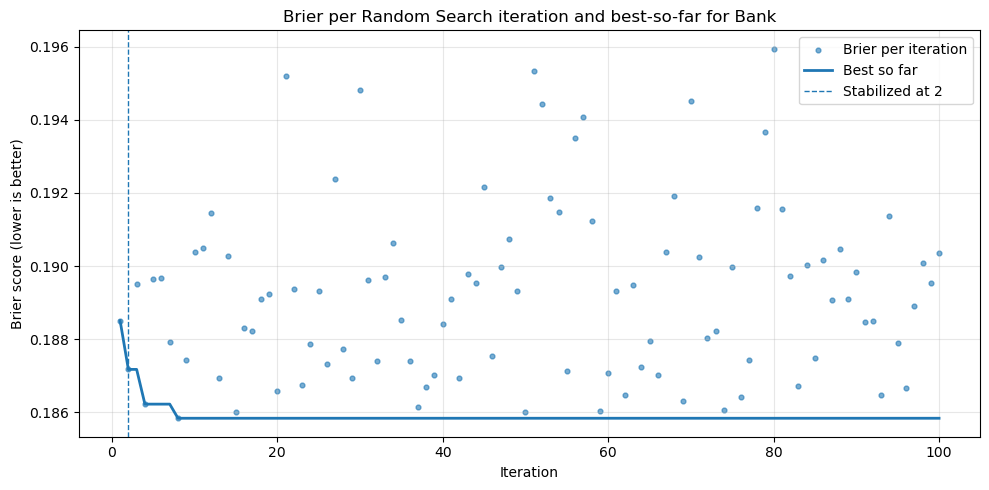

Tuning datasets:  25%|██▌       | 1/4 [1:03:29<3:10:27, 3809.04s/it]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


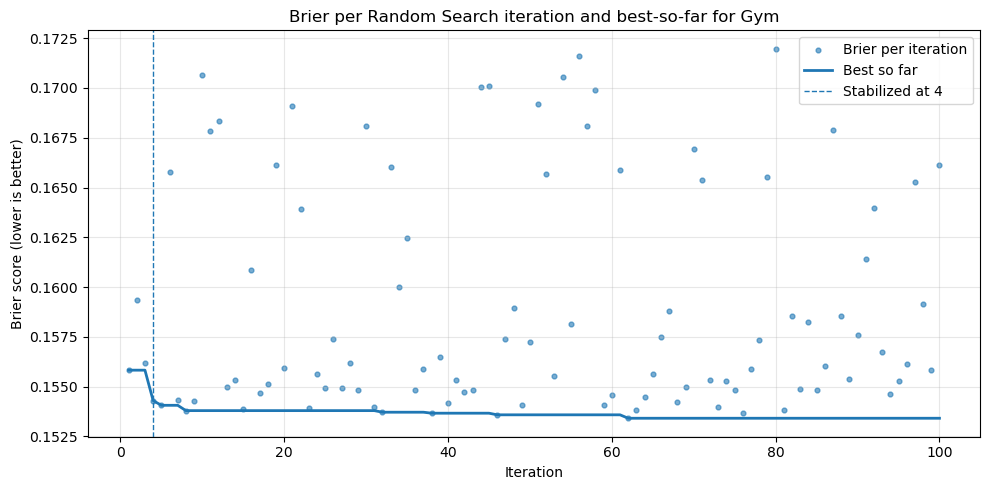

Tuning datasets:  50%|█████     | 2/4 [1:26:39<1:19:33, 2386.56s/it]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


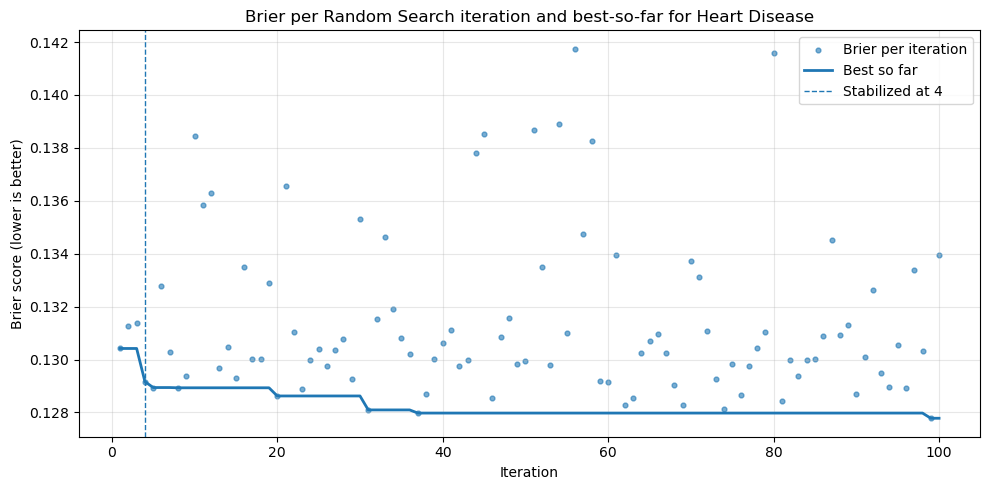

Tuning datasets:  75%|███████▌  | 3/4 [1:42:47<28:58, 1738.74s/it]  

Fitting 5 folds for each of 100 candidates, totalling 500 fits


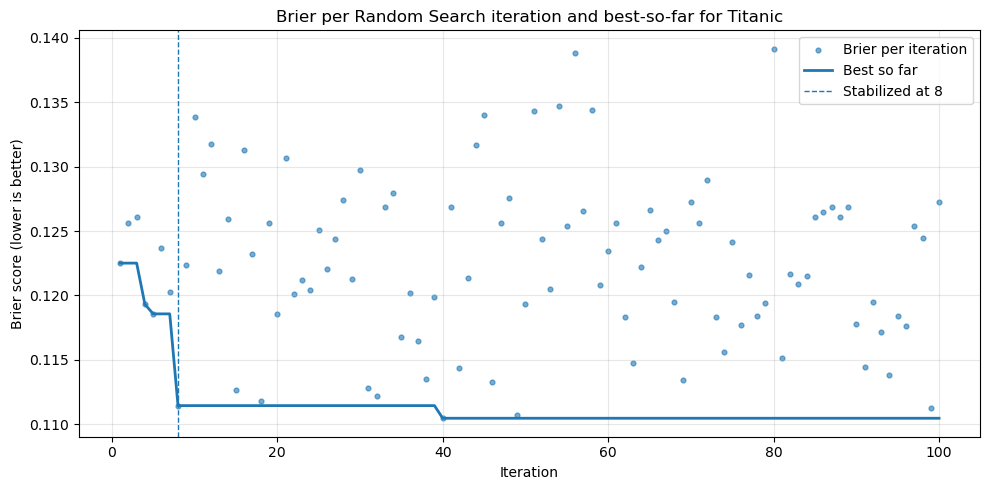

Tuning datasets: 100%|██████████| 4/4 [1:58:03<00:00, 1770.89s/it]


In [14]:
for X_train, X_test, y_train, y_test, dataset_name in tqdm(datasets, desc="Tuning datasets"):
    # Fit the RandomizedSearchCV (or other search object) on training fold
    random_search.fit(X_train, y_train)

    model = random_search.best_estimator_
    
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)

    cv_results = random_search.cv_results_
    best_params = random_search.best_params_.copy()  # dict

    tuned_brier_scores.append(brier)
    best_params_list.append(best_params)
    cv_results_list.append(cv_results)

    
    mean_test_score = -cv_results['mean_test_score']  # Negate if using neg_log_loss
    best_so_far = np.minimum.accumulate(mean_test_score)

    # detect stabilization (1-based iteration returned)
    stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len=WINDOW_SIZE)
    # Prepare data for plotting
    iters = np.arange(1, len(mean_test_score) + 1)

    # Plot the results for this dataset
    chart_random(stabilized_at, mean_test_score, iters, best_so_far, dataset_name)

### Random Search Results

In [15]:
# Combine all cv_results into one DataFrame
all_results = []
for i, cv_res in enumerate(cv_results_list):
    df = pd.DataFrame(cv_res)
    dataset_name = datasets[i][4]  # adjust if your dataset tuple differs
    df["dataset"] = dataset_name
    df["brier_score"] = -df["mean_test_score"]  # Use each trial's CV score, not the test score
    all_results.append(df)

# Merge into one full DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

# Keep the most informative columns
cols_to_keep = [
    "dataset",
    "params",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
    "mean_fit_time",
    "mean_score_time",
    "brier_score"
]
existing_cols = [c for c in cols_to_keep if c in all_results_df.columns]
results_to_save = all_results_df[existing_cols]

# Save all model evaluations
results_to_save.to_csv("RandomForestData/all_randomsearch_results.csv", index=False)
print(f"Saved {len(all_results_df)} rows to RandomForestData/all_randomsearch_results.csv")

# Extract best model per dataset
best_rows = all_results_df.loc[all_results_df.groupby("dataset")["rank_test_score"].idxmin()]
best_rows = best_rows.sort_values("dataset").reset_index(drop=True)
best_rows.to_csv("RandomForestData/best_models_summary.csv", index=False)
print(f"Saved {len(best_rows)} best model summaries to RandomForestData/best_models_summary.csv")

# Plot convergence charts
# for i, cv_res in enumerate(cv_results_list):
#     dataset_name = datasets[i][4]
#     cv_results = cv_res
#     mean_test_score = -np.array(cv_results["mean_test_score"])  # negate if using neg metric
#     iters = np.arange(1, len(mean_test_score) + 1)
#     best_so_far = np.minimum.accumulate(mean_test_score)

#     stabilized_at, stabilized_value = detect_stabilization_by_last(
#         best_so_far,
#         abs_tol=ABS_TOL,
#         window_len=WINDOW_SIZE
#     )

#     chart_random(stabilized_at, mean_test_score, iters, best_so_far, dataset_name)

# plt.tight_layout()
# plt.show()


Saved 400 rows to RandomForestData/all_randomsearch_results.csv
Saved 4 best model summaries to RandomForestData/best_models_summary.csv


In [16]:
pd.set_option('display.max_colwidth', 300)


# Ensure we work with a copy
df = pd.read_csv("RandomForestData/all_randomsearch_results.csv")
#df = all_results_df.copy()
# Sort within each dataset by brier_score ascending (lower is better)
df_sorted = df.sort_values(by=["dataset", "mean_test_score"], ascending=[True, False])

# Get top 10 per dataset
top10_per_dataset = df_sorted.groupby("dataset").head(10).reset_index(drop=True)

# Show in console
for dataset_name, subset in top10_per_dataset.groupby("dataset"):
    print(f"\nTop 10 models for dataset: {dataset_name}")
    display(subset[["dataset", "rank_test_score", "mean_test_score", "params"]])



Top 10 models for dataset: Bank


,dataset,rank_test_score,mean_test_score,params
0,Bank,1,-0.185842,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1469}"
1,Bank,2,-0.186004,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.25, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 18, 'n_estimators': 116}"
2,Bank,3,-0.186013,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 747}"
3,Bank,4,-0.186051,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 16, 'n_estimators': 1215}"
4,Bank,5,-0.186081,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.25, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 1115}"
5,Bank,6,-0.186141,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.25, 'max_samples': 0.9, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 588}"
6,Bank,7,-0.186228,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.33, 'max_samples': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 1437}"
7,Bank,8,-0.186309,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 0.25, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1209}"
8,Bank,9,-0.186416,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 4, 'min_samples_split': 13, 'n_estimators': 789}"
9,Bank,10,-0.186468,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 0.25, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 18, 'n_estimators': 610}"



Top 10 models for dataset: Gym


,dataset,rank_test_score,mean_test_score,params
10,Gym,1,-0.153414,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 1319}"
11,Gym,2,-0.153586,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 1258}"
12,Gym,3,-0.153661,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 4, 'min_samples_split': 13, 'n_estimators': 789}"
13,Gym,4,-0.153667,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'max_samples': 0.9, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 740}"
14,Gym,5,-0.153717,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1253}"
15,Gym,6,-0.153797,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1469}"
16,Gym,7,-0.153812,"{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1019}"
17,Gym,8,-0.153841,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 755}"
18,Gym,9,-0.153869,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 747}"
19,Gym,10,-0.153908,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'max_samples': 0.7, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 848}"



Top 10 models for dataset: Heart Disease


,dataset,rank_test_score,mean_test_score,params
20,Heart Disease,1,-0.127779,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.25, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1033}"
21,Heart Disease,2,-0.127975,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.25, 'max_samples': 0.9, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 588}"
22,Heart Disease,3,-0.128094,"{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 0.33, 'max_samples': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 741}"
23,Heart Disease,4,-0.128114,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.25, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 1115}"
24,Heart Disease,5,-0.128285,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 0.25, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1209}"
25,Heart Disease,6,-0.128285,"{'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 1319}"
26,Heart Disease,7,-0.128428,"{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 1019}"
27,Heart Disease,8,-0.128544,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 1258}"
28,Heart Disease,9,-0.128557,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 755}"
29,Heart Disease,10,-0.128622,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 0.25, 'max_samples': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 742}"



Top 10 models for dataset: Titanic


,dataset,rank_test_score,mean_test_score,params
30,Titanic,1,-0.110454,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 996}"
31,Titanic,2,-0.110715,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.33, 'max_samples': 0.9, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1119}"
32,Titanic,3,-0.111235,"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.25, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1033}"
33,Titanic,4,-0.111435,"{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1469}"
34,Titanic,5,-0.111801,"{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1171}"
35,Titanic,6,-0.112210,"{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1253}"
36,Titanic,7,-0.112648,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 747}"
37,Titanic,8,-0.112831,"{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 0.33, 'max_samples': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 741}"
38,Titanic,9,-0.113234,"{'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 1258}"
39,Titanic,10,-0.113412,"{'criterion': 'log_loss', 'max_depth': 20, 'max_features': 0.25, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1209}"


### Results short

In [17]:
for i, (brier, baseline_brier, params, (_, _, _, _, dataset_name)) in enumerate(zip(tuned_brier_scores, baseline_brier_scores, best_params_list, datasets), 1):
    print(f"""
    Dataset {i} ({dataset_name}): 
        Tuned Brier score = {brier:.4f}, Baseline Brier score = {baseline_brier:.4f} \n
    Best parameters:
        n_estimators: {params['n_estimators']:.4f}
        criterion: {params['criterion']}
        max_depth:{params['max_depth']}
        min_samples_split:{params['min_samples_split']}
        min_samples_leaf:{params['min_samples_leaf']}
        max_features:{params['max_features']}
    """)


    Dataset 1 (Bank): 
        Tuned Brier score = 0.1847, Baseline Brier score = 0.1892 

    Best parameters:
        n_estimators: 1469.0000
        criterion: entropy
        max_depth:None
        min_samples_split:10
        min_samples_leaf:2
        max_features:sqrt
    

    Dataset 2 (Gym): 
        Tuned Brier score = 0.1775, Baseline Brier score = 0.1819 

    Best parameters:
        n_estimators: 1319.0000
        criterion: log_loss
        max_depth:None
        min_samples_split:8
        min_samples_leaf:5
        max_features:0.33
    

    Dataset 3 (Heart Disease): 
        Tuned Brier score = 0.1050, Baseline Brier score = 0.1067 

    Best parameters:
        n_estimators: 1033.0000
        criterion: entropy
        max_depth:10
        min_samples_split:2
        min_samples_leaf:1
        max_features:0.25
    

    Dataset 4 (Titanic): 
        Tuned Brier score = 0.1516, Baseline Brier score = 0.1520 

    Best parameters:
        n_estimators: 996.0000
  

## Bayesian Optimization

In [18]:
def bayes_optimize(X_loc, y_arr, n_trials=N_ITER, cv=CV, random_state=RANDOM_STATE, n_jobs_model=1, pruner_n_startup_trials=10, verbose=True):
    y_arr = np.asarray(y_arr).ravel()
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    sampler = optuna.samplers.TPESampler(seed=random_state)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=pruner_n_startup_trials, n_warmup_steps=0, interval_steps=1)
    
    # Suppress optuna logging
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

    # Track best score for console output
    best_score = -np.inf #####
    
    def objective(trial):
        nonlocal best_score         #####
        
        params = param_distributions_bayes(trial)
        
        # Match the exact parameter distributions from random search
        # params = {
        #     'n_estimators': trial.suggest_int('n_estimators', 100, 1499),
        #     'criterion': trial.suggest_categorical('criterion', ['log_loss', 'entropy', 'gini']),
        #     'max_depth': trial.suggest_categorical('max_depth', [10, 15, 20, None]),
        #     'min_samples_split': trial.suggest_int('min_samples_split', 2, 19),
        #     'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 9),
        #     'max_features': trial.suggest_categorical('max_features', ['sqrt', 0.1, 0.33]),
        #     'max_samples': trial.suggest_categorical('max_samples', [0.5, 0.7, 0.9, None])
        # }



        model = RandomForestClassifier(**params, random_state=random_state, n_jobs=n_jobs_model)

        neg_briers = []

        for fold_idx, (train_idx, val_idx) in enumerate(cv_splitter.split(X_loc, y_arr)):
            X_tr = X_loc.iloc[train_idx] #if hasattr(X_loc, 'iloc') else X_loc[train_idx]
            X_val = X_loc.iloc[val_idx] #if hasattr(X_loc, 'iloc') else X_loc[val_idx]
            y_tr = y_arr[train_idx]
            y_val = y_arr[val_idx]

            model.fit(X_tr, y_tr)

            probs = model.predict_proba(X_val)[:, 1]
            neg_brier = -brier_score_loss(y_val, probs)
            neg_briers.append(neg_brier)

            mean_neg_so_far = float(np.mean(neg_briers))
            trial.report(mean_neg_so_far, step=fold_idx)
            if trial.should_prune():
                raise optuna.TrialPruned()
            
        mean_neg = float(np.mean(neg_briers))
        


        # Print only when new best is found
        if verbose and mean_neg > best_score:
            best_score = mean_neg
            brier_score = -mean_neg
            params_str = f"n_est={params['n_estimators']}, crit={params['criterion']}, depth={params['max_depth']}, " \
                        f"split={params['min_samples_split']}, leaf={params['min_samples_leaf']}, feat={params['max_features']}"
            print(f"  Trial {trial.number:3d}: Brier={brier_score:.4f} | {params_str}")
        


        return mean_neg
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False) #####

    trials = study.trials
    neg_scores = [t.value if t.value is not None else np.nan for t in trials]
    brier_per_iter = -np.array(neg_scores, dtype=float)

    best_so_far = []
    current_best = np.inf
    for v in brier_per_iter:
        if np.isnan(v):
            best_so_far.append(current_best if current_best != np.inf else np.nan)
        else:
            if v < current_best:
                current_best = v
            best_so_far.append(current_best)
    best_so_far = np.array(best_so_far, dtype=float)

    completed = [t for t in trials if t.state == TrialState.COMPLETE and t.value is not None]
    best_trial = max(completed, key=lambda tr: tr.value)
    best_params = best_trial.params
    best_brier = float(best_trial.value)

    return {
        'brier_per_iter': brier_per_iter,
        'best_so_far': best_so_far,
        'best_params': best_params,
        'best_brier': best_brier,
        'study': study  # Return study object for trial data extraction
    }

In [19]:
bayes_brier_scores = []
bayes_best_params_list = []
bayes_results_list = []

Bayesian Tuning:   0%|          | 0/4 [00:00<?, ?it/s]


Optimizing Bank dataset...
  Trial   0: Brier=0.1897 | n_est=624, crit=log_loss, depth=None, split=12, leaf=7, feat=0.1
  Trial   1: Brier=0.1859 | n_est=704, crit=entropy, depth=None, split=5, leaf=5, feat=0.25
  Trial   9: Brier=0.1858 | n_est=986, crit=gini, depth=None, split=14, leaf=1, feat=0.25
  Trial  13: Brier=0.1858 | n_est=1145, crit=gini, depth=None, split=13, leaf=1, feat=0.25
  Trial  22: Brier=0.1856 | n_est=1046, crit=gini, depth=None, split=13, leaf=2, feat=0.25
  Trial  23: Brier=0.1855 | n_est=1021, crit=gini, depth=None, split=15, leaf=2, feat=0.25
  Trial  30: Brier=0.1853 | n_est=854, crit=log_loss, depth=None, split=17, leaf=3, feat=0.25
  Trial  55: Brier=0.1851 | n_est=1410, crit=log_loss, depth=None, split=19, leaf=2, feat=0.25
  Trial  56: Brier=0.1851 | n_est=1425, crit=log_loss, depth=None, split=19, leaf=2, feat=0.25
  Trial  58: Brier=0.1851 | n_est=1375, crit=entropy, depth=None, split=19, leaf=2, feat=0.25


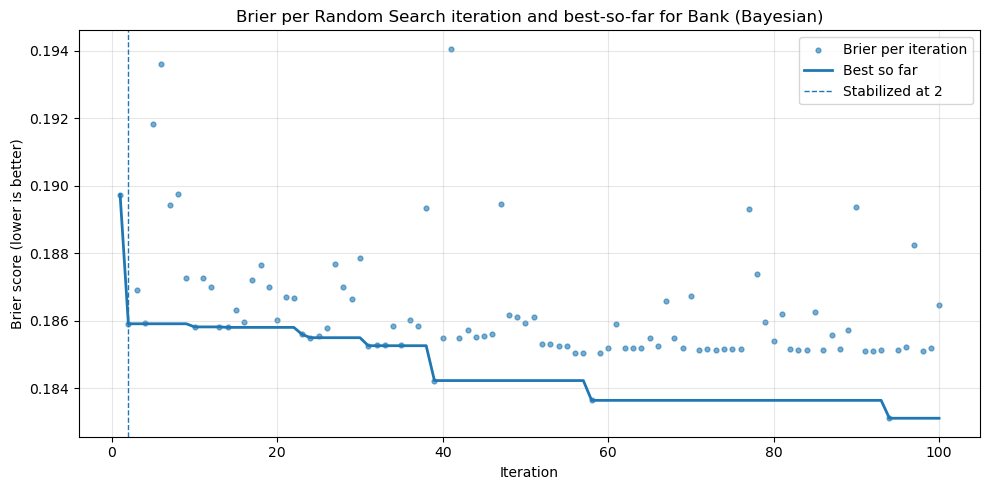

Bayesian Tuning:  25%|██▌       | 1/4 [1:24:08<4:12:24, 5048.17s/it]


✓ Final test Brier: 0.1843
✓ Stabilized at iteration: 2

Optimizing Gym dataset...
  Trial   0: Brier=0.1676 | n_est=624, crit=log_loss, depth=None, split=12, leaf=7, feat=0.1
  Trial   1: Brier=0.1569 | n_est=704, crit=entropy, depth=None, split=5, leaf=5, feat=0.25
  Trial   3: Brier=0.1554 | n_est=937, crit=log_loss, depth=20, split=16, leaf=4, feat=0.33
  Trial   8: Brier=0.1549 | n_est=498, crit=entropy, depth=20, split=4, leaf=5, feat=sqrt
  Trial  11: Brier=0.1549 | n_est=955, crit=log_loss, depth=20, split=9, leaf=4, feat=0.33
  Trial  12: Brier=0.1549 | n_est=999, crit=log_loss, depth=15, split=9, leaf=4, feat=sqrt
  Trial  13: Brier=0.1548 | n_est=1122, crit=log_loss, depth=15, split=10, leaf=3, feat=0.33
  Trial  14: Brier=0.1548 | n_est=1271, crit=log_loss, depth=15, split=11, leaf=3, feat=sqrt
  Trial  22: Brier=0.1548 | n_est=1088, crit=log_loss, depth=15, split=10, leaf=3, feat=sqrt
  Trial  26: Brier=0.1547 | n_est=1078, crit=log_loss, depth=15, split=7, leaf=4, feat=s

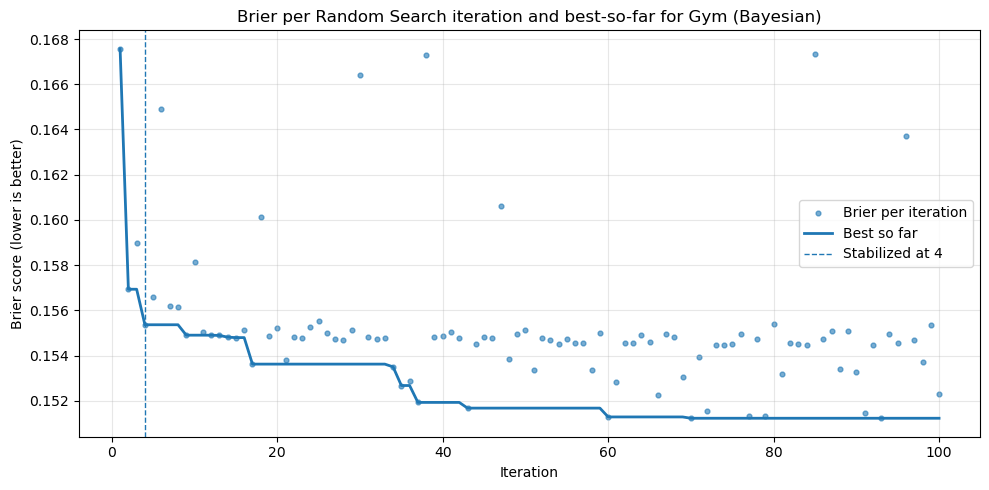

Bayesian Tuning:  50%|█████     | 2/4 [1:37:25<1:24:55, 2547.92s/it]


✓ Final test Brier: 0.1786
✓ Stabilized at iteration: 4

Optimizing Heart Disease dataset...
  Trial   0: Brier=0.1348 | n_est=624, crit=log_loss, depth=None, split=12, leaf=7, feat=0.1
  Trial   1: Brier=0.1275 | n_est=704, crit=entropy, depth=None, split=5, leaf=5, feat=0.25
  Trial  11: Brier=0.1273 | n_est=923, crit=gini, depth=None, split=11, leaf=1, feat=0.25
  Trial  13: Brier=0.1268 | n_est=1065, crit=gini, depth=None, split=8, leaf=3, feat=0.25
  Trial  15: Brier=0.1268 | n_est=1173, crit=gini, depth=15, split=9, leaf=3, feat=0.25
  Trial  16: Brier=0.1268 | n_est=1206, crit=gini, depth=15, split=8, leaf=3, feat=0.25
  Trial  20: Brier=0.1266 | n_est=1336, crit=gini, depth=15, split=3, leaf=2, feat=0.25
  Trial  21: Brier=0.1265 | n_est=1365, crit=gini, depth=15, split=2, leaf=2, feat=0.25
  Trial  22: Brier=0.1265 | n_est=1382, crit=gini, depth=15, split=2, leaf=2, feat=0.25
  Trial  23: Brier=0.1265 | n_est=1419, crit=gini, depth=15, split=2, leaf=2, feat=0.25
  Trial  25: 

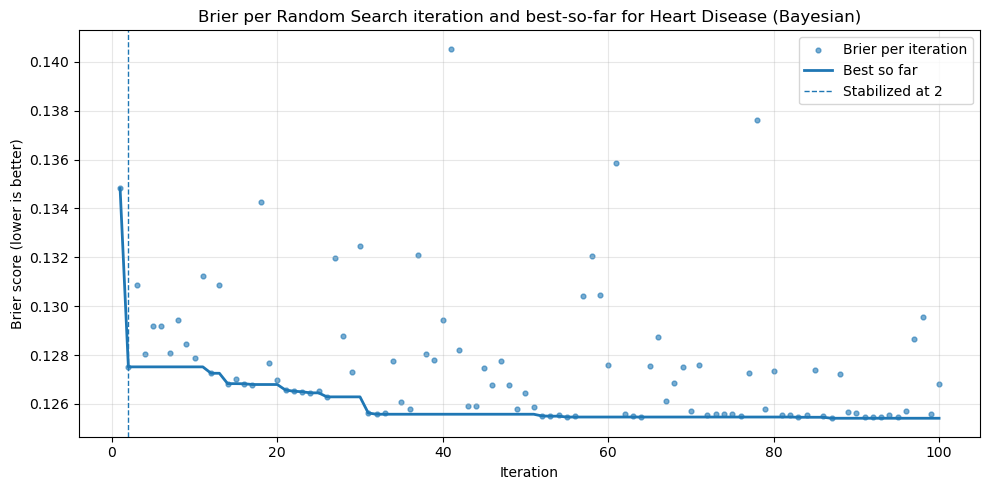

Bayesian Tuning:  75%|███████▌  | 3/4 [1:51:20<29:25, 1765.41s/it]  


✓ Final test Brier: 0.1044
✓ Stabilized at iteration: 2

Optimizing Titanic dataset...
  Trial   0: Brier=0.1296 | n_est=624, crit=log_loss, depth=None, split=12, leaf=7, feat=0.1
  Trial   1: Brier=0.1200 | n_est=704, crit=entropy, depth=None, split=5, leaf=5, feat=0.25
  Trial   5: Brier=0.1196 | n_est=267, crit=entropy, depth=10, split=2, leaf=1, feat=0.1
  Trial   6: Brier=0.1184 | n_est=420, crit=entropy, depth=10, split=16, leaf=2, feat=0.33
  Trial  10: Brier=0.1176 | n_est=1423, crit=gini, depth=15, split=9, leaf=3, feat=0.33
  Trial  13: Brier=0.1174 | n_est=1498, crit=gini, depth=15, split=8, leaf=3, feat=0.33
  Trial  23: Brier=0.1165 | n_est=1369, crit=gini, depth=15, split=8, leaf=2, feat=0.33
  Trial  24: Brier=0.1164 | n_est=1103, crit=gini, depth=15, split=7, leaf=1, feat=0.33
  Trial  27: Brier=0.1160 | n_est=1097, crit=gini, depth=15, split=6, leaf=1, feat=sqrt
  Trial  28: Brier=0.1153 | n_est=852, crit=log_loss, depth=20, split=5, leaf=1, feat=sqrt
  Trial  73: Bri

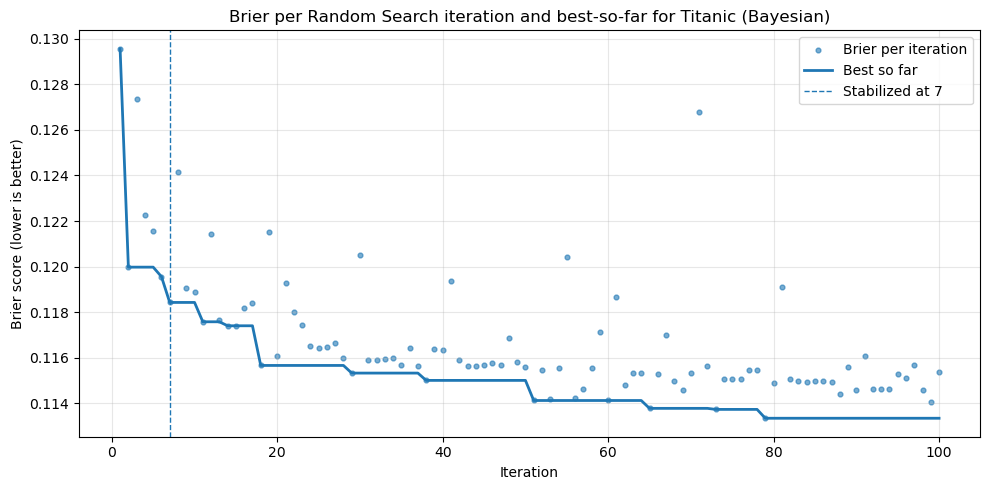

Bayesian Tuning: 100%|██████████| 4/4 [2:01:45<00:00, 1826.38s/it]


✓ Final test Brier: 0.1521
✓ Stabilized at iteration: 7

Saved all Bayesian trials to RandomForestData/all_bayesian_results.csv
Saved individual dataset trials to RandomForestData/bayesian_trials_[dataset].csv


In [20]:
all_bayesian_trials = [] #####

for X_train, X_test, y_train, y_test, dataset_name in tqdm(datasets, desc="Bayesian Tuning"):
    print(f"\n{'='*60}")
    print(f"Optimizing {dataset_name} dataset...")
    print(f"{'='*60}")
    
    # Run Bayesian optimization
    result = bayes_optimize(X_train, y_train, n_trials=N_ITER, n_jobs_model=N_JOBS, verbose=True)
    
    # Extract best parameters
    best_params = result['best_params']
    bayes_best_params_list.append(best_params)
    bayes_results_list.append(result)
    
    # Train final model with best parameters and evaluate on test set
    model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)
    bayes_brier_scores.append(brier)
    
    # Extract all trials from study
    study = result['study']
    trials_data = []
    for trial in study.trials:
        trial_dict = {
            'trial_number': trial.number,
            'state': str(trial.state),
            'value': trial.value if trial.value is not None else np.nan,
            'brier_score': -trial.value if trial.value is not None else np.nan,
            'duration': trial.duration.total_seconds() if trial.duration else np.nan,
            'params': str(trial.params),
            **trial.params  # Unpack parameters as separate columns
        }
        trials_data.append(trial_dict)
    
    # Create DataFrame for this dataset
    trials_df = pd.DataFrame(trials_data)
    trials_df['dataset'] = dataset_name
    trials_df['test_brier_score'] = brier
    
    # Save individual dataset trials
    trials_df.to_csv(f'RandomForestData/bayesian_trials_{dataset_name.replace(" ", "_")}.csv', index=False)
    all_bayesian_trials.append(trials_df)
    
    # Visualization
    brier_per_iter = result['brier_per_iter']
    best_so_far = result['best_so_far']
    
    # Detect stabilization
    stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len=WINDOW_SIZE)
    
    # Plot
    iters = np.arange(1, len(brier_per_iter) + 1)
    chart_random(stabilized_at, brier_per_iter, iters, best_so_far, f"{dataset_name} (Bayesian)")
    
    # Final summary
    print(f"\n✓ Final test Brier: {brier:.4f}")
    if stabilized_at:
        print(f"✓ Stabilized at iteration: {stabilized_at}")

# Combine all trials
all_bayesian_df = pd.concat(all_bayesian_trials, ignore_index=True)
all_bayesian_df.to_csv('RandomForestData/all_bayesian_results.csv', index=False)

print(f"\n{'='*60}")
print(f"Saved all Bayesian trials to RandomForestData/all_bayesian_results.csv")
print(f"Saved individual dataset trials to RandomForestData/bayesian_trials_[dataset].csv")
print(f"{'='*60}")

## Detailed Results Comparison

In [5]:
# Load Random Search results
rs_results_df = pd.read_csv('RandomForestData/all_randomsearch_results.csv')
rs_best_models = pd.read_csv('RandomForestData/best_models_summary.csv')

# Load Bayesian Optimization results
bayes_results_df = pd.read_csv('RandomForestData/all_bayesian_results.csv')

print(f"Loaded Random Search: {len(rs_results_df)} trials")
print(f"Loaded Bayesian Optimization: {len(bayes_results_df)} trials")


# Reconstruct the variables needed for comparison from loaded data
dataset_names = ['Bank', 'Gym', 'Heart Disease', 'Titanic']

# Extract test brier scores from loaded data
tuned_brier_scores = []
bayes_brier_scores = []

for ds_name in dataset_names:
    # Random Search - get test brier score from best model
    rs_best = rs_best_models[rs_best_models['dataset'] == ds_name]['brier_score'].values[0]
    tuned_brier_scores.append(rs_best)
    
    # Bayesian - get test brier score (unique per dataset)
    bayes_test = bayes_results_df[bayes_results_df['dataset'] == ds_name]['test_brier_score'].values[0]
    bayes_brier_scores.append(bayes_test)

# print("\nRandom Search Test Brier Scores:")
# for ds, score in zip(dataset_names, tuned_brier_scores):
#     print(f"  {ds}: {score:.4f}")

# print("\nBayesian Opt Test Brier Scores:")
# for ds, score in zip(dataset_names, bayes_brier_scores):
#     print(f"  {ds}: {score:.4f}")

Loaded Random Search: 400 trials
Loaded Bayesian Optimization: 400 trials


In [6]:
# Create comparison using loaded data
comparison_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Baseline': baseline_brier_scores,  # This was computed from actual data
    'Random Search': tuned_brier_scores,
    'Bayesian Opt': bayes_brier_scores
})

comparison_df['RS Improvement'] = ((comparison_df['Baseline'] - comparison_df['Random Search']) / comparison_df['Baseline'] * 100).round(2)
comparison_df['Bayes Improvement'] = ((comparison_df['Baseline'] - comparison_df['Bayesian Opt']) / comparison_df['Baseline'] * 100).round(2)
comparison_df['Bayes vs RS'] = ((comparison_df['Random Search'] - comparison_df['Bayesian Opt']) / comparison_df['Random Search'] * 100).round(2)

print("="*60)
print("Brier Score Comparison (Loaded from Files)")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)
print("\nLower Brier scores are better")
print("Improvement % = (Baseline - Method) / Baseline * 100")

Brier Score Comparison (Loaded from Files)
      Dataset  Baseline  Random Search  Bayesian Opt  RS Improvement  Bayes Improvement  Bayes vs RS
         Bank  0.189193       0.185842      0.184323            1.77               2.57         0.82
          Gym  0.181900       0.153414      0.178621           15.66               1.80       -16.43
Heart Disease  0.106674       0.127779      0.104411          -19.78               2.12        18.29
      Titanic  0.152039       0.110454      0.152059           27.35              -0.01       -37.67

Lower Brier scores are better
Improvement % = (Baseline - Method) / Baseline * 100


In [23]:
for i, (_, _, _, _, dataset_name) in enumerate(datasets):
    print(f"\n{'='*60}")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*60}")
    
    print(f"\nBrier Scores:")
    print(f"  Baseline:       {baseline_brier_scores[i]:.4f}")
    print(f"  Random Search:  {tuned_brier_scores[i]:.4f} (improvement: {comparison_df.loc[i, 'RS Improvement']:.2f}%)")
    print(f"  Bayesian Opt:   {bayes_brier_scores[i]:.4f} (improvement: {comparison_df.loc[i, 'Bayes Improvement']:.2f}%)")
    
    print(f"\nBest Parameters - Random Search:")
    for key, value in best_params_list[i].items():
        print(f"  {key}: {value}")
    
    print(f"\nBest Parameters - Bayesian Optimization:")
    for key, value in bayes_best_params_list[i].items():
        print(f"  {key}: {value}")


Dataset: Bank

Brier Scores:
  Baseline:       0.1892
  Random Search:  0.1858 (improvement: 1.77%)
  Bayesian Opt:   0.1843 (improvement: 2.57%)

Best Parameters - Random Search:
  criterion: entropy
  max_depth: None
  max_features: sqrt
  max_samples: None
  min_samples_leaf: 2
  min_samples_split: 10
  n_estimators: 1469

Best Parameters - Bayesian Optimization:
  n_estimators: 1375
  criterion: entropy
  max_depth: None
  min_samples_split: 19
  min_samples_leaf: 2
  max_features: 0.25
  max_samples: 0.9

Dataset: Gym

Brier Scores:
  Baseline:       0.1819
  Random Search:  0.1534 (improvement: 15.66%)
  Bayesian Opt:   0.1786 (improvement: 1.80%)

Best Parameters - Random Search:
  criterion: log_loss
  max_depth: None
  max_features: 0.33
  max_samples: None
  min_samples_leaf: 5
  min_samples_split: 8
  n_estimators: 1319

Best Parameters - Bayesian Optimization:
  n_estimators: 412
  criterion: log_loss
  max_depth: 20
  min_samples_split: 4
  min_samples_leaf: 5
  max_featu

### Top 10 best parameters

In [24]:
pd.set_option('display.max_colwidth', 300)

# Load Bayesian results
df_bayes = pd.read_csv("RandomForestData/all_bayesian_results.csv")

# Filter only completed trials (state=1 means COMPLETE, state=2 means PRUNED)
df_bayes_completed = df_bayes[df_bayes['state'] == 1].copy()

# Sort within each dataset by brier_score ascending (lower is better)
df_bayes_sorted = df_bayes_completed.sort_values(by=["dataset", "brier_score"], ascending=[True, True])

# Get top 10 per dataset
top10_bayes_per_dataset = df_bayes_sorted.groupby("dataset").head(10).reset_index(drop=True)

# Show in console
for dataset_name, subset in top10_bayes_per_dataset.groupby("dataset"):
    print(f"\nTop 10 models for dataset: {dataset_name}")
    
    # Create a simplified params view
    display_cols = ["dataset", "trial_number", "brier_score", "n_estimators", "criterion", "max_depth", 
                   "min_samples_split", "min_samples_leaf", "max_features", "max_samples"]
    
    # Filter to only columns that exist
    display_cols = [col for col in display_cols if col in subset.columns]
    
    display(subset[display_cols])


Top 10 models for dataset: Bank


,dataset,trial_number,brier_score,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,max_features,max_samples
0,Bank,58,0.185051,1375,entropy,NaN,19,2,0.25,0.9
1,Bank,56,0.185053,1425,log_loss,NaN,19,2,0.25,0.9
2,Bank,55,0.185065,1410,log_loss,NaN,19,2,0.25,0.9
3,Bank,97,0.185118,1315,entropy,NaN,17,2,0.25,0.9
4,Bank,90,0.185123,1450,entropy,NaN,17,2,0.25,0.9
5,Bank,91,0.185124,1446,entropy,NaN,17,2,0.25,0.9
6,Bank,94,0.185125,1451,entropy,NaN,17,2,0.25,0.9
7,Bank,92,0.185125,1452,entropy,NaN,17,2,0.25,0.9
8,Bank,83,0.185126,1453,entropy,NaN,17,2,0.25,0.9
9,Bank,85,0.185128,1423,entropy,NaN,17,2,0.25,0.9



Top 10 models for dataset: Gym


,dataset,trial_number,brier_score,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,max_features,max_samples
10,Gym,72,0.154476,412,log_loss,20.0,4,5,0.33,0.9
11,Gym,73,0.154489,405,log_loss,20.0,3,5,0.33,0.9
12,Gym,91,0.154491,437,log_loss,20.0,5,5,0.33,0.9
13,Gym,83,0.154491,411,log_loss,20.0,4,5,0.33,0.9
14,Gym,53,0.154493,404,log_loss,20.0,6,5,sqrt,0.9
15,Gym,43,0.154520,489,log_loss,15.0,2,5,sqrt,0.9
16,Gym,74,0.154524,403,log_loss,20.0,3,5,0.33,0.9
17,Gym,82,0.154529,401,log_loss,20.0,4,5,0.33,0.9
18,Gym,55,0.154538,457,log_loss,20.0,7,5,0.33,0.9
19,Gym,56,0.154542,462,log_loss,20.0,8,5,0.33,0.9



Top 10 models for dataset: Heart Disease


,dataset,trial_number,brier_score,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,max_features,max_samples
20,Heart Disease,82,0.125451,1449,entropy,10.0,2,1,0.25,0.9
21,Heart Disease,91,0.125453,1221,entropy,10.0,2,1,0.25,0.9
22,Heart Disease,92,0.125454,1219,entropy,10.0,2,1,0.25,0.9
23,Heart Disease,90,0.125456,1214,entropy,10.0,2,1,0.25,0.9
24,Heart Disease,94,0.125457,1226,entropy,10.0,2,1,0.25,0.9
25,Heart Disease,54,0.125461,1249,entropy,10.0,2,1,0.25,0.9
26,Heart Disease,63,0.125468,1441,entropy,10.0,2,1,0.25,0.9
27,Heart Disease,52,0.125496,1242,entropy,10.0,2,1,0.25,0.9
28,Heart Disease,62,0.125504,1430,entropy,10.0,2,1,0.25,0.9
29,Heart Disease,55,0.125504,1427,entropy,10.0,2,1,0.25,0.9



Top 10 models for dataset: Titanic


,dataset,trial_number,brier_score,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,max_features,max_samples
30,Titanic,87,0.114411,1216,log_loss,10.0,8,1,sqrt,0.9
31,Titanic,89,0.114580,1200,log_loss,10.0,9,1,sqrt,0.9
32,Titanic,97,0.114611,1286,log_loss,10.0,9,1,sqrt,0.9
33,Titanic,92,0.114616,1388,log_loss,10.0,9,1,sqrt,0.9
34,Titanic,93,0.114626,1384,log_loss,10.0,9,1,sqrt,0.9
35,Titanic,91,0.114635,1376,log_loss,10.0,9,1,sqrt,0.9
36,Titanic,79,0.114910,1255,log_loss,20.0,8,1,sqrt,0.9
37,Titanic,86,0.114920,1225,log_loss,20.0,8,1,sqrt,0.9
38,Titanic,83,0.114929,1227,log_loss,20.0,8,1,sqrt,0.9
39,Titanic,85,0.114965,1215,log_loss,20.0,8,1,sqrt,0.9


### Visualisation

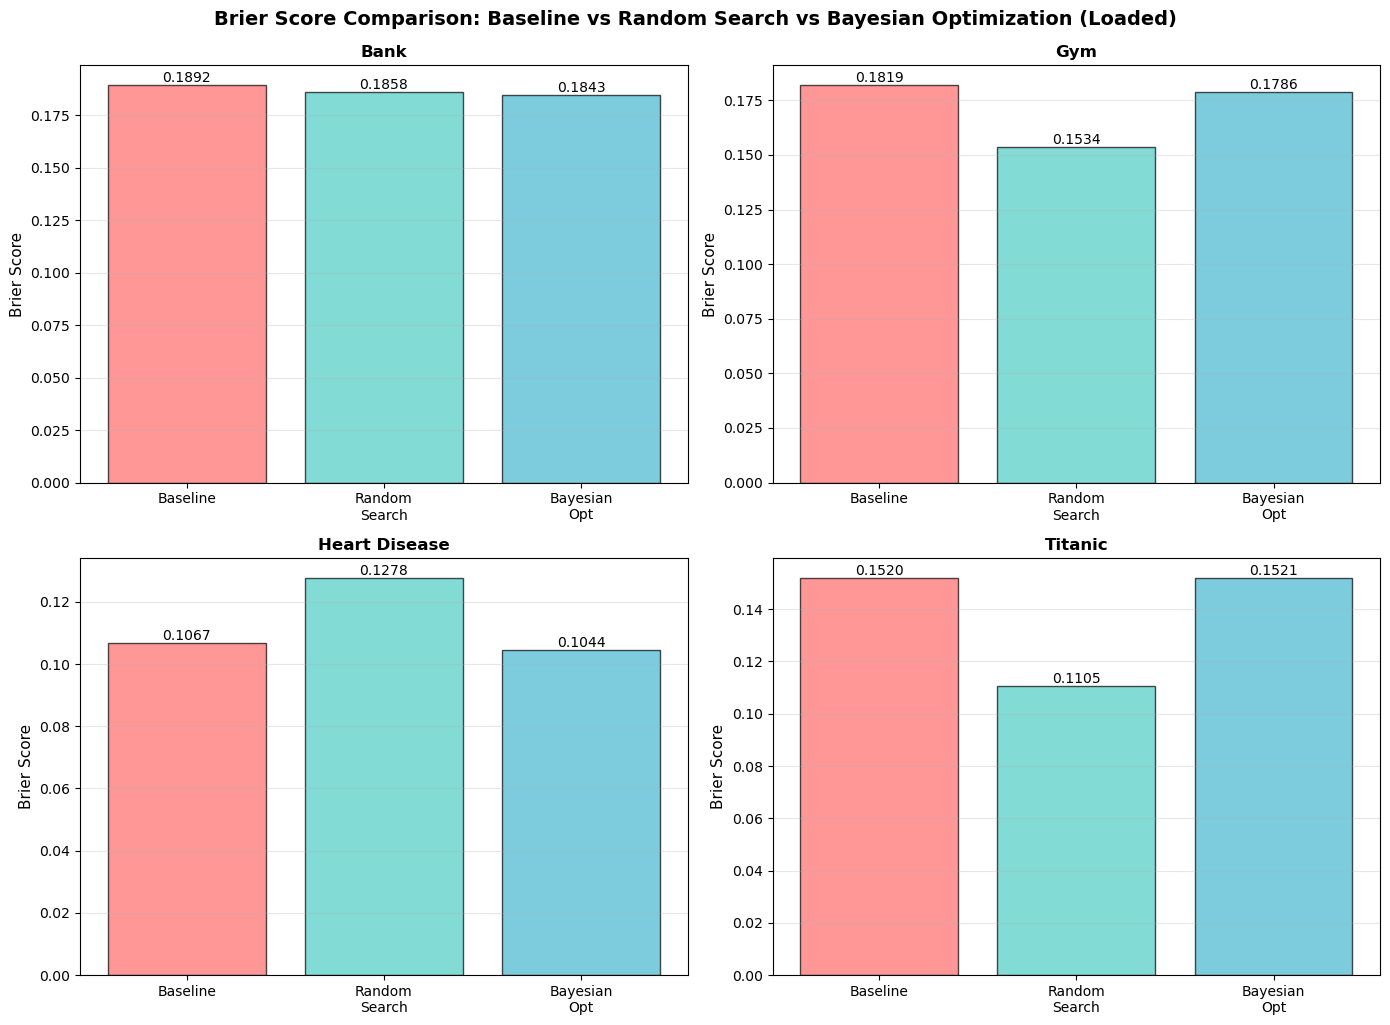

In [25]:
# Visualize comparison using loaded data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (dataset_name, ax) in enumerate(zip(dataset_names, axes)):
    methods = ['Baseline', 'Random\nSearch', 'Bayesian\nOpt']
    scores = [baseline_brier_scores[i], tuned_brier_scores[i], bayes_brier_scores[i]]
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    
    bars = ax.bar(methods, scores, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Brier Score', fontsize=11)
    ax.set_title(f'{dataset_name}', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.4f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle('Brier Score Comparison: Baseline vs Random Search vs Bayesian Optimization (Loaded)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

## Dataset Size Impact: Bank Data (25%, 50%, 75%, 100%)

Testing how Random Search and Bayesian optimization perform on different subsets of the Bank dataset. This will show how the amount of training data affects hyperparameter optimization effectiveness.

In [26]:
def calculate_brier_randomsearch_subsets(X, y):
    """
    Test Random Search on different subsets (25%, 50%, 75%, 100%) of the data.
    For 100%, loads existing results from files instead of re-running.
    Returns DataFrame with results for each fraction.
    """
    fractions = [0.25, 0.5, 0.75, 1.0]
    results = []
    
    for frac in fractions:
        print(f"\n{'='*60}")
        print(f"Random Search - Testing with {int(frac*100)}% of data")
        print(f"{'='*60}")
        
        # For 100%, load existing results from files
        if frac == 1.0:
            print("Loading existing results from files (already computed)...")
            
            # Load best model results
            rs_best = pd.read_csv('RandomForestData/best_models_summary.csv')
            bank_best = rs_best[rs_best['dataset'] == 'Bank'].iloc[0]

            # Extract parameters from params column (it's a string representation of dict)
            import ast
            best_params = ast.literal_eval(bank_best['params']) ## little difference from just best_params=bank_best['params'] but ok
            best_brier_cv = -bank_best['mean_test_score']  # Negate back to positive
            brier_test = bank_best['brier_score']
            
            # Get training size (80% of full dataset)
            n_samples_train = int(len(X) * 0.8)
            
            print(f"Brier (CV, best): {best_brier_cv:.5f} | Brier (test): {brier_test:.5f}")
            
            results.append({
                'frac': frac,
                'method': 'Random Search',
                'best_params': best_params,
                'brier_cv': best_brier_cv,
                'brier_test': brier_test,
                'n_samples_train': n_samples_train
            })
            continue
        
        # For other fractions, run optimization
        # Create subset
        X_sub, _, y_sub, _ = train_test_split(
            X, y, train_size=frac, stratify=y, random_state=RANDOM_STATE)
        
        # Split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X_sub, y_sub, test_size=0.2, stratify=y_sub, random_state=RANDOM_STATE)
        
        # Run Random Search
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS)
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_distributions_randomsearch,
            n_iter=N_ITER,
            scoring=SCORER,
            cv=CV,
            verbose=0,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            refit=True
        )
        
        random_search.fit(X_train, y_train)
        
        # Get best parameters and CV score
        best_params = random_search.best_params_
        best_brier_cv = -random_search.best_score_  # Negate because we used neg_brier_score
        
        # Evaluate on test set
        best_model = random_search.best_estimator_
        y_proba = best_model.predict_proba(X_test)[:, 1]
        brier_test = brier_score_loss(y_test, y_proba)
        
        print(f"Brier (CV, best): {best_brier_cv:.5f} | Brier (test): {brier_test:.5f}")
        
        results.append({
            'frac': frac,
            'method': 'Random Search',
            'best_params': best_params,
            'brier_cv': best_brier_cv,
            'brier_test': brier_test,
            'n_samples_train': len(X_train)
        })
    
    return pd.DataFrame(results)

In [27]:
def calculate_brier_bayes_subsets(X, y):
    """
    Test Bayesian optimization on different subsets (25%, 50%, 75%, 100%) of the data.
    For 100%, loads existing results from files instead of re-running.
    Returns DataFrame with results for each fraction.
    """
    fractions = [0.25, 0.5, 0.75, 1.0]
    results = []
    
    for frac in fractions:
        print(f"\n{'='*60}")
        print(f"Bayesian Optimization - Testing with {int(frac*100)}% of data")
        print(f"{'='*60}")
        
        # For 100%, load existing results from files
        if frac == 1.0:
            print("Loading existing results from files (already computed)...")
            
            # Load Bayesian results
            bayes_df = pd.read_csv('RandomForestData/all_bayesian_results.csv')
            # Filter for Bank dataset
            bank_trials = bayes_df[bayes_df['dataset'] == 'Bank']

            # Get best trial (lowest brier_score) - state 1 appears to be completed trials
            bank_completed = bank_trials[bank_trials['state'] == 1]
            best_trial = bank_completed.loc[bank_completed['brier_score'].idxmin()]
            
            # Extract parameters
            best_params = {
                'n_estimators': int(best_trial['n_estimators']),
                'criterion': best_trial['criterion'],
                'max_depth': None if pd.isna(best_trial['max_depth']) or best_trial['max_depth'] == 'None' else int(best_trial['max_depth']),
                'min_samples_split': int(best_trial['min_samples_split']),
                'min_samples_leaf': int(best_trial['min_samples_leaf']),
                'max_features': best_trial['max_features'] if best_trial['max_features'] == 'sqrt' else float(best_trial['max_features']),
                'max_samples': None if pd.isna(best_trial['max_samples']) or best_trial['max_samples'] == 'None' else float(best_trial['max_samples'])
            }
            
            best_brier_cv = best_trial['brier_score']
            brier_test = best_trial['test_brier_score']
            
            # Get training size (80% of full dataset)
            n_samples_train = int(len(X) * 0.8)
            
            print(f"Brier (CV, best): {best_brier_cv:.5f} | Brier (test): {brier_test:.5f}")
            
            results.append({
                'frac': frac,
                'method': 'Bayesian Opt',
                'best_params': best_params,
                'brier_cv': best_brier_cv,
                'brier_test': brier_test,
                'n_samples_train': n_samples_train
            })
            continue
        
        # For other fractions, run optimization
        # Create subset
        X_sub, _, y_sub, _ = train_test_split(
            X, y, train_size=frac, stratify=y, random_state=RANDOM_STATE
        )
        
        # Split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X_sub, y_sub, test_size=0.2, stratify=y_sub, random_state=RANDOM_STATE
        )
        
        # Run Bayesian optimization
        res = bayes_optimize(
            X_train, y_train,
            n_jobs_model=N_JOBS,
            verbose=True
        )
        
        best_params = res.get('best_params')
        best_brier_cv = -res.get('best_brier')  # Negate because bayes_optimize returns negative
        
        # Evaluate on test set
        final_model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=N_JOBS)
        final_model.fit(X_train, y_train)
        y_proba = final_model.predict_proba(X_test)[:, 1]
        brier_test = brier_score_loss(y_test, y_proba)
        
        print(f"Brier (CV, best): {best_brier_cv:.5f} | Brier (test): {brier_test:.5f}")
        
        results.append({
            'frac': frac,
            'method': 'Bayesian Opt',
            'best_params': best_params,
            'brier_cv': best_brier_cv,
            'brier_test': brier_test,
            'n_samples_train': len(X_train)
        })
    
    return pd.DataFrame(results)

### Run Random Search on Bank Data Subsets

In [28]:
rs_subset_results = calculate_brier_randomsearch_subsets(X1, y1)


Random Search - Testing with 25% of data
Brier (CV, best): 0.19173 | Brier (test): 0.19436

Random Search - Testing with 50% of data
Brier (CV, best): 0.18702 | Brier (test): 0.19277

Random Search - Testing with 75% of data
Brier (CV, best): 0.18516 | Brier (test): 0.19231

Random Search - Testing with 100% of data
Loading existing results from files (already computed)...
Brier (CV, best): 0.18584 | Brier (test): 0.18584


In [29]:
# Save Random Search subset results to file
rs_subset_results.to_csv('RandomForestData/randomsearch_subsets_bank.csv', index=False)
print(f"Saved Random Search subset results to RandomForestData/randomsearch_subsets_bank.csv")

Saved Random Search subset results to RandomForestData/randomsearch_subsets_bank.csv


### Run Bayesian Optimization on Bank Data Subsets

In [30]:
bayes_subset_results = calculate_brier_bayes_subsets(X1, y1)


Bayesian Optimization - Testing with 25% of data
  Trial   0: Brier=0.1988 | n_est=624, crit=log_loss, depth=None, split=12, leaf=7, feat=0.1
  Trial   1: Brier=0.1953 | n_est=704, crit=entropy, depth=None, split=5, leaf=5, feat=0.25
  Trial   9: Brier=0.1947 | n_est=986, crit=gini, depth=None, split=14, leaf=1, feat=0.25
  Trial  26: Brier=0.1940 | n_est=1332, crit=gini, depth=20, split=15, leaf=1, feat=sqrt
  Trial  36: Brier=0.1940 | n_est=1413, crit=gini, depth=20, split=15, leaf=1, feat=sqrt
  Trial  37: Brier=0.1937 | n_est=667, crit=entropy, depth=20, split=17, leaf=1, feat=sqrt
Brier (CV, best): 0.19372 | Brier (test): 0.19491

Bayesian Optimization - Testing with 50% of data
  Trial   0: Brier=0.1918 | n_est=624, crit=log_loss, depth=None, split=12, leaf=7, feat=0.1
  Trial   1: Brier=0.1876 | n_est=704, crit=entropy, depth=None, split=5, leaf=5, feat=0.25
  Trial  13: Brier=0.1871 | n_est=1065, crit=gini, depth=None, split=8, leaf=3, feat=0.25
  Trial  15: Brier=0.1869 | n_e

In [31]:
# Save Bayesian subset results to file
bayes_subset_results.to_csv('RandomForestData/bayesian_subsets_bank.csv', index=False)
print(f"Saved Bayesian subset results to RandomForestData/bayesian_subsets_bank.csv")

Saved Bayesian subset results to RandomForestData/bayesian_subsets_bank.csv


### Compare Results and Visualize

In [32]:
# Combine results
all_subset_results = pd.concat([rs_subset_results, bayes_subset_results], ignore_index=True)

# Save to file
all_subset_results.to_csv('RandomForestData/subset_comparison_results.csv', index=False)
print(f"Saved subset comparison results to RandomForestData/subset_comparison_results.csv")

# Display results table
print("\n" + "="*60)
print("Results Summary: Random Search vs Bayesian Optimization on Bank Data Subsets")
print("="*60)

# Create comparison view
comparison_view = all_subset_results[['frac', 'method', 'n_samples_train', 'brier_cv', 'brier_test']].copy()
comparison_view['dataset_size_%'] = (comparison_view['frac'] * 100).astype(int)
comparison_view = comparison_view[['dataset_size_%', 'method', 'n_samples_train', 'brier_cv', 'brier_test']]
comparison_view = comparison_view.sort_values(['dataset_size_%', 'method'])

display(comparison_view)

Saved subset comparison results to RandomForestData/subset_comparison_results.csv

Results Summary: Random Search vs Bayesian Optimization on Bank Data Subsets


,dataset_size_%,method,n_samples_train,brier_cv,brier_test
4,25,Bayesian Opt,2232,0.193720,0.194910
0,25,Random Search,2232,0.191727,0.194361
5,50,Bayesian Opt,4464,0.186541,0.194906
1,50,Random Search,4464,0.187018,0.192765
6,75,Bayesian Opt,6696,0.185457,0.192134
2,75,Random Search,6696,0.185161,0.192312
7,100,Bayesian Opt,8929,0.185051,0.184323
3,100,Random Search,8929,0.185842,0.185842


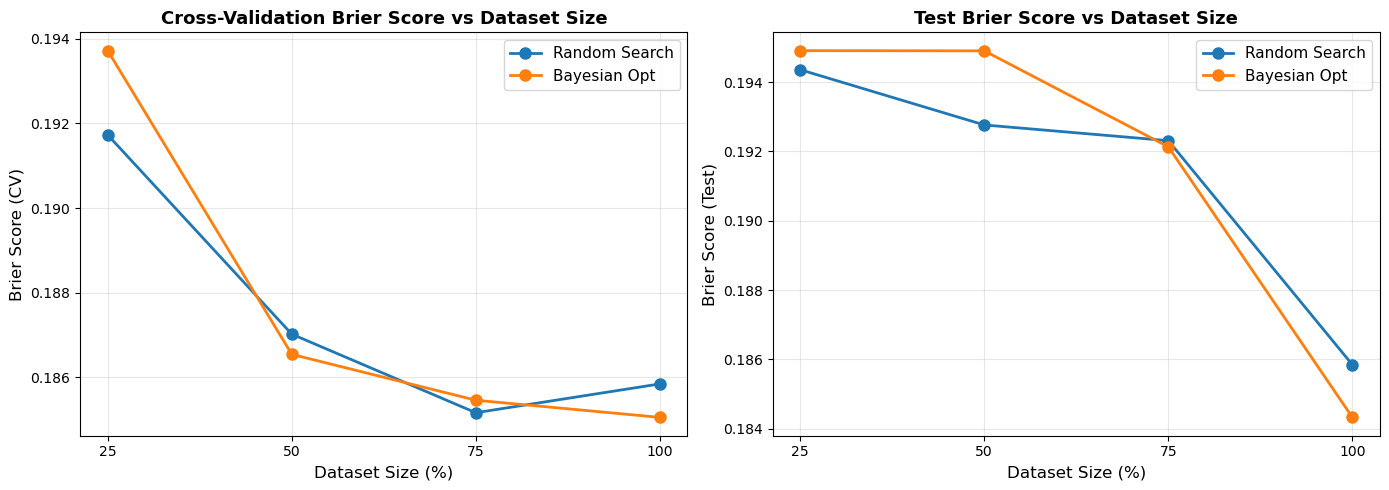

In [33]:
# Visualization: Brier Score vs Dataset Size
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: CV Brier Score
ax1 = axes[0]
for method in ['Random Search', 'Bayesian Opt']:
    data = all_subset_results[all_subset_results['method'] == method]
    ax1.plot(data['frac'] * 100, data['brier_cv'], marker='o', linewidth=2, 
             markersize=8, label=method)

ax1.set_xlabel('Dataset Size (%)', fontsize=12)
ax1.set_ylabel('Brier Score (CV)', fontsize=12)
ax1.set_title('Cross-Validation Brier Score vs Dataset Size', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks([25, 50, 75, 100])

# Plot 2: Test Brier Score
ax2 = axes[1]
for method in ['Random Search', 'Bayesian Opt']:
    data = all_subset_results[all_subset_results['method'] == method]
    ax2.plot(data['frac'] * 100, data['brier_test'], marker='o', linewidth=2, 
             markersize=8, label=method)

ax2.set_xlabel('Dataset Size (%)', fontsize=12)
ax2.set_ylabel('Brier Score (Test)', fontsize=12)
ax2.set_title('Test Brier Score vs Dataset Size', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks([25, 50, 75, 100])

plt.tight_layout()
plt.show()

In [ ]:
# Calculate and display improvement percentages
print("\n" + "="*60)
print("Performance Improvement Analysis")
print("="*60)

for frac in [0.25, 0.5, 0.75, 1.0]:
    rs_data = all_subset_results[(all_subset_results['method'] == 'Random Search') & 
                                  (all_subset_results['frac'] == frac)].iloc[0]
    bayes_data = all_subset_results[(all_subset_results['method'] == 'Bayesian Opt') & 
                                     (all_subset_results['frac'] == frac)].iloc[0]
    
    cv_diff = rs_data['brier_cv'] - bayes_data['brier_cv']
    test_diff = rs_data['brier_test'] - bayes_data['brier_test']
    
    cv_pct = (cv_diff / rs_data['brier_cv']) * 100
    test_pct = (test_diff / rs_data['brier_test']) * 100
    
    winner_cv = "Bayesian" if cv_diff > 0 else "Random Search"
    winner_test = "Bayesian" if test_diff > 0 else "Random Search"
    
    print(f"\nDataset Size: {int(frac*100)}% (n_train={rs_data['n_samples_train']})")
    print(f"  CV Score:   RS={rs_data['brier_cv']:.5f}, Bayes={bayes_data['brier_cv']:.5f} "
          f"(Winner: {winner_cv}, {abs(cv_pct):.2f}% 'better')")
    print(f"  Test Score: RS={rs_data['brier_test']:.5f}, Bayes={bayes_data['brier_test']:.5f} "
          f"(Winner: {winner_test}, {abs(test_pct):.2f}% 'better')")

print("\n" + "="*60)


Performance Improvement Analysis

Dataset Size: 25% (n_train=2232)
  CV Score:   RS=0.19173, Bayes=0.19372 (Winner: Random Search, 1.04% 'better')
  Test Score: RS=0.19436, Bayes=0.19491 (Winner: Random Search, 0.28% 'better')

Dataset Size: 50% (n_train=4464)
  CV Score:   RS=0.18702, Bayes=0.18654 (Winner: Bayesian, 0.26% 'better')
  Test Score: RS=0.19277, Bayes=0.19491 (Winner: Random Search, 1.11% 'better')

Dataset Size: 75% (n_train=6696)
  CV Score:   RS=0.18516, Bayes=0.18546 (Winner: Random Search, 0.16% 'better')
  Test Score: RS=0.19231, Bayes=0.19213 (Winner: Bayesian, 0.09% 'better')

Dataset Size: 100% (n_train=8929)
  CV Score:   RS=0.18584, Bayes=0.18505 (Winner: Bayesian, 0.43% 'better')
  Test Score: RS=0.18584, Bayes=0.18432 (Winner: Bayesian, 0.82% 'better')



In [ ]:
default = [0.1892, 0.1819, 0.1067, 0.1520]
new = [0.19491, ]